# Studying minimum allowable distance between spiral tips
Tim Tyree<br>
4.18.2021

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from numba import njit
#load the libraries
from lib import *

from lib.my_initialization import *
from lib.controller.controller_LR import get_one_step_explicit_synchronous_splitting
from lib.model.LR_model import *
from lib.utils.utils_traj import *
from lib.routines.bdrates import *
from lib.measure.utils_measure_tips_cpu import *
from lib.utils.stack_txt_LR import *
from lib.viewer import *
import trackpy
from lib.utils import load_buffer

#automate the boring stuff
# from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
    
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# euclidean distance between dying tips appears to go to zero

## initialize a token case repeatably for Luo-Rudy model (~15 min runtime)

In [3]:
# ic_fn=search_for_file()
ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-out/ic008.33.npz"
txt=load_buffer(ic_fn)
t=0

In [4]:
# get_one_step
dt, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,
    dt=0.01,
    width=200,
    height=200,
    ds=5.0,
    diffCoef=0.0005,
    Cm=1.0)

In [44]:
inVc, outVc, inmhjdfx, outmhjdfx, dVcdt=unstack_txt(txt.copy())

In [6]:
tf=200.
while t<tf:
    one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
    t+=dt

In [8]:
txt=stack_txt(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)

#save texture at this time t
save=True
if save:
#     txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    save_img_fn=os.path.basename(ic_fn).replace('.npz',f'_t_{t:.1f}.npz')
    save_img_folder=f"{nb_dir}/Data/test_data/"
    os.chdir(save_img_folder)
    #     img_out=txt#np.stack([img,dimgdt]).T
    np.savez_compressed(save_img_fn,[txt])
    print(f"t={t}")

t=200.00999999996307


In [12]:
os.path.abspath(save_img_fn)

'/home/timothytyree/Documents/GitHub/care/notebooks/Data/test_data/ic008.33_t_200.0.npz'

In [39]:
txt.shape

(1, 200, 200, 18)

In [9]:
#test timestep updates all channels
inVc0, outVc0, inmhjdfx0, outmhjdfx0, dVcdt0=unstack_txt(txt)
assert (np.max(np.abs(inVc0-inVc))>0)
assert (np.max(np.abs(outVc0-outVc))>0)
assert (np.max(np.abs(inmhjdfx0-inmhjdfx))>0)
assert (np.max(np.abs(outmhjdfx0-outmhjdfx))>0)
assert (np.max(np.abs(dVcdt0-dVcdt))>0)

In [42]:
width=200;height=200
compute_all_spiral_tips=get_compute_all_spiral_tips(width, height, mode='simp')

In [ ]:
#compute all spiral tips present
V_threshold=-50.#mV
level1=V_threshold
# theta_threshold=0.
level2=0.
#take the first step
inVc, outVc, inmhjdfx, outmhjdfx, dVcdt=unstack_txt(txt.copy())
one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
t+=dt
img=inVc[...,0]
dimgdt=dVcdt[...,0]
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2)
dict_out_instantaneous=dict_out
print(np.max(inVc[...,0]))
dict_out_instantaneous

In [1]:
x_values=np.array(dict_out['x'])
y_values=np.array(dict_out['y'])
c_values=np.array(dict_out['x'])
print(f"{dict_out['n']} tips are present at time t={int(t)}.")
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
                 area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=True,axis=[0,200,0,200])
plt.show(fig)

NameError: name 'np' is not defined

In [39]:
txt=stack_txt(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)

#save texture at this time t
save=True
if save:
#     txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    save_img_fn=os.path.basename(ic_fn).replace('.npz',f'_t_{t:.0f}.npz')
    save_img_folder=f"{nb_dir}/Data/test_data/"
    os.chdir(save_img_folder)
    #     img_out=txt#np.stack([img,dimgdt]).T
    np.savez_compressed(save_img_fn,[txt])

In [49]:
# os.path.abspath(save_img_fn)
txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_200.0.npz'
txt=load_buffer(txt_fn)[0].T
t=200
#TODO: save txt as txt_save regularly at time t_save
#TODO: time step until a spiral tip death occurs

## (ignore) look through archive of spiral tips for a nice death event

In [27]:
#DONE: detect all spiral tips present
#TODO: compute r=minimum distance between all spiral tips 
#TODO: record r given current time step
#TODO: repeat ^that death event using half the time step.  Is r different? ...If not, be sure before continuing.

# get_one_step
dt, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,
    dt=0.01,
    width=200,
    height=200,
    ds=5.0,
    diffCoef=0.001,
    Cm=1.0)

width=200;height=200
compute_all_spiral_tips=get_compute_all_spiral_tips(width, height, mode='simp')

In [4]:
# filename=search_for_file()
filename="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_50_diffCoef_0.001/trajectories/ic008.33_traj_sr_600_mem_0.csv"

File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_50_diffCoef_0.001/trajectories/ic008.33_traj_sr_600_mem_0.csv


In [5]:
#determine the first time of death
df=pd.read_csv(filename)
df.head()

,t,n,x,y,grad_ux,grad_uy,grad_vx,grad_vy,frame,particle
0,100.1,4,76.107144,95.769295,2.122038,0.110608,3.848873,-1.268491,0,0
1,100.1,4,138.428533,177.960260,1.425500,0.669138,0.559806,1.344284,0,1
2,100.1,4,145.710107,103.460688,1.490384,0.305823,0.463274,1.750858,0,2
3,100.1,4,172.360040,199.042657,1.714722,0.384820,7.247116,-4.410005,0,3
4,102.1,4,76.078799,97.642564,2.174351,0.088509,4.100056,-1.418567,1,0


In [6]:
dff=df.groupby('frame').n.mean()

In [12]:
death_frame_values=dff[dff.diff()==-2].index.values


In [18]:
t_lst=[]
for frm in death_frame_values:
    t_lst.append(df[df.frame==frm].t.mean())

In [40]:
inVc, outVc, inmhjdfx, outmhjdfx, dVcdt=unstack_txt(txt.copy())

In [41]:
txt_lst=[]
for tf in t_lst[:8]:
    while t<tf-1:
        one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
        t+=dt
    txt=stack_txt(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
    txt_lst.append(txt)

In [42]:
beep(4)

0

In [43]:
len(txt_lst)

8

## (ignore) identify an LR death event for zooming into

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


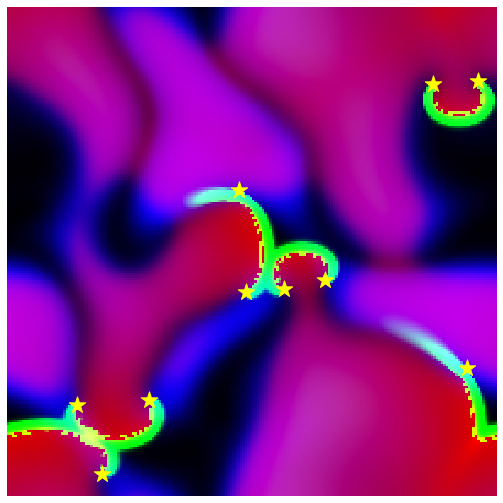

In [60]:
#test the V_threshold value
j=1
q=7
V_threshold=-50.
level1 = V_threshold
t=-999
level2 = 0.
# ic=input_fn_lst[j]
# txt=load_buffer(ic)#input_fn)
txt=txt_lst[q]
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
t=t_lst[q]
width,height=txt.shape[:2]

img=inVc[...,0]
dimgdt=dVcdt[...,0]
# compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2)#,width=width,height=height)
print(len(list(dict_out['x'])))
fig=show_buffer_LR(txt)
axs=fig.get_axes()
ax=axs[0]
ax.scatter(dict_out['x'],dict_out['y'],s=300,c='yellow',marker='*')
plt.show()

In [62]:
# txt=stack_txt(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)

#save texture at this time t
save=True
if save:
#     txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    save_img_fn=os.path.basename(ic_fn).replace('.npz',f'_t_{t:.1f}.npz')
    save_img_folder=f"{nb_dir}/Data/test_data/"
    os.chdir(save_img_folder)
    #     img_out=txt#np.stack([img,dimgdt]).T
    np.savez_compressed(save_img_fn,txt)

## advance in time until two tips annihilate.  identify the location of annihilation.

In [22]:
txt_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/test_data/ic008.33_t_200.0.npz'
txt=load_buffer(txt_fn).astype('float64')
t=200.0

In [29]:
def get_tip_locations(inVc,dVcdt,t,level1=-50.,level2=0.):
    # inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
    #     width,height=txt.shape[:2]
    img=inVc[...,0]
    dimgdt=dVcdt[...,0]
    dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2)#,width=width,height=height)
    return np.array(dict_out['x']),np.array(dict_out['y'])

In [30]:
get_tip_locations(inVc,dVcdt,t,level1=-50.,level2=0.)

TypeError: only size-1 arrays can be converted to Python scalars

In [24]:
x_values,y_values=get_tip_locations(inVc,dVcdt,t,level1=-50.,level2=0.)
n_tips=x_values.shape[0]
n_tips_current=n_tips
n_tips_current

TypeError: only size-1 arrays can be converted to Python scalars

In [175]:

while n_tips>=n_tips_current:
    txt_prev=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    x_values_prev=x_values.copy()
    y_values_prev=y_values.copy()
    one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
    t+=dt
    x_values,y_values=get_tip_locations(inVc,dVcdt,level1=-50.,level2=0.)
    n_tips=x_values.shape[0]
print(t)
print(n_tips)
txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

697.9399999997692
4


6 tips are present at time t=696.99.


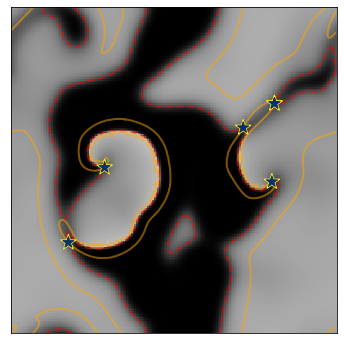

In [191]:
beep(10)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt_prev)
img=inVc[...,0]
dimgdt=dVcdt[...,0]
# compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2)#,width=width,height=height)
x_values=np.array(dict_out['x'])
y_values=np.array(dict_out['y'])
c_values=np.array(dict_out['x'])
print(f"{dict_out['n']} tips are present at time t={int(t)-dt}.")
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
                 area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
# fig = ShowDomain(img,dimgdt,np.array([xyavg[0]]),np.array([xyavg[1]]),np.array([0]),V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
#                  area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
# ax=fig.get_axes()[0]
# ax.scatter([xyavg[0]],[xyavg[1]],s=1000,c='yellow',marker='*')
# plt.show(fig)

In [21]:
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
img=inVc[...,0]
dimgdt=dVcdt[...,0]
# compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2)#,width=width,height=height)
x_values=np.array(dict_out['x'])
y_values=np.array(dict_out['y'])
c_values=np.array(dict_out['x'])
print(f"{dict_out['n']} tips are present at time t={int(t)}.")
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
                 area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
# fig = ShowDomain(img,dimgdt,np.array([xyavg[0]]),np.array([xyavg[1]]),np.array([0]),V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
#                  area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
# ax=fig.get_axes()[0]
# ax.scatter([xyavg[0]],[xyavg[1]],s=1000,c='yellow',marker='*')
# plt.show(fig)

TypeError: only size-1 arrays can be converted to Python scalars

In [181]:
print(sorted(zip(x_values_prev,y_values_prev)))
print(sorted(zip(x_values,y_values)))

[(55.72387513287924, 35.35097954340235), (92.97183554041425, 160.15211296795283), (101.70677120695012, 57.57169828133864), (126.0918613651391, 142.53495599204214), (140.96357241847184, 161.7024554609346), (141.0044240236116, 161.70930304941754)]
[(35.35097954340239, 55.723875132878995), (57.571698281338065, 101.7067712069501), (142.5349559920376, 126.09186136513908), (160.15211296790588, 92.97183554040545), (161.70245546093162, 140.96357241844856), (161.7093030494175, 141.0044240236156)]


In [196]:
dist=get_distance_L2_pbc(width=width, height=height)

In [182]:
print(x_values_prev)
print(x_values)

[ 55.72387513  92.97183554 101.70677121 126.09186137 140.96357242
 141.00442402]
[ 35.35097954  57.57169828 142.53495599 160.15211297 161.70245546
 161.70930305]


In [201]:
imin=np.argmin(np.diff(x_values_prev))
xy1=np.array(sorted(zip(x_values_prev,y_values_prev))[imin])
xy2=np.array(sorted(zip(x_values_prev,y_values_prev))[imin+1])
#compute distance between these two spiral tips before death
r=dist(xy1,xy2)
#compute average location of these two spiral tips before death
xyavg=(xy1+xy2)/2.


In [188]:
# #view the death location and verify that it looks reasonable
# # print(len(list(dict_out['x'])))
# txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
# fig=show_buffer_LR(txt)
# axs=fig.get_axes()
# ax=axs[0]
# ax.scatter(dict_out['x'],dict_out['y'],s=300,c='yellow',marker='*')
# ax.scatter([xyavg[0]],[xyavg[1]],s=500,c='blue',marker='*')
# plt.show()

In [189]:
#Save the validated death event
# txt=stack_txt(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)

#save texture at this time t
save=True
if save:
#     txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    save_img_fn=os.path.basename(ic_fn).replace('.npz',f'_t_{t:.1f}.npz')
    save_img_folder=f"{nb_dir}/Data/test_data/"
    os.chdir(save_img_folder)
    #     img_out=txt#np.stack([img,dimgdt]).T
    np.savez_compressed(save_img_fn,txt_prev)
print(os.path.abspath(save_img_fn))

/home/timothytyree/Documents/GitHub/care/notebooks/Data/test_data/ic008.33_t_697.9.npz


## measure minimum distance versus dt with high spatial resolution

In [20]:
zoomin_txt

<function lib.utils.zoom_array.zoomin_txt(txt_in)>

In [ ]:
# txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_750.0.npz'
# t=750.
txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_900.0.npz'
t=900.

txt_prev=load_buffer(txt_fn)
width,height=txt_prev.shape[:2]
width,height

In [2]:
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt_prev)
img=inVc[...,0]
dimgdt=dVcdt[...,0]
V_threshold=-50
compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
x_values=np.array(dict_out['x'])
y_values=np.array(dict_out['y'])
c_values=np.array(dict_out['x'])
print(f"{dict_out['n']} tips are present at time t={int(t)}.")
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
                 area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
# fig = ShowDomain(img,dimgdt,np.array([xyavg[0]]),np.array([xyavg[1]]),np.array([0]),V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
#                  area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
# ax=fig.get_axes()[0]
# ax.scatter([xyavg[0]],[xyavg[1]],s=1000,c='yellow',marker='*')
# plt.show(fig)

NameError: name 'txt_prev' is not defined

In [3]:
#Time step until there are no more tips... saving every 50 and keeping the most recent 
t_save=t+50
t_prev=t
# txt_prev=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt_prev)
x_values,y_values=get_tip_locations(inVc,dVcdt,level1=-50.,level2=0.)#slow
n_tips=x_values.shape[0]
while n_tips>0:
    one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
    t+=dt
    if t>t_save:
        t_save+=30.
        t_prev=t
        txt_prev=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)#slow
        x_values,y_values=get_tip_locations(inVc,dVcdt,level1=-50.,level2=0.)
        n_tips=x_values.shape[0]
print(f"termination event observed before time t={t:.3f}.")
beep(10)

NameError: name 't' is not defined

In [ ]:
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt_prev)
img=inVc[...,0]
dimgdt=dVcdt[...,0]
V_threshold=-50
# compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
x_values=np.array(dict_out['x'])
y_values=np.array(dict_out['y'])
c_values=np.array(dict_out['x'])
print(f"{dict_out['n']} tips are present at time t={int(t)}.")
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
                 area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
# fig = ShowDomain(img,dimgdt,np.array([xyavg[0]]),np.array([xyavg[1]]),np.array([0]),V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
#                  area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
# ax=fig.get_axes()[0]
# ax.scatter([xyavg[0]],[xyavg[1]],s=1000,c='yellow',marker='*')
# plt.show(fig)

In [7]:
# x_values,y_values=get_tip_locations(inVc,dVcdt,level1=-50.,level2=0.)
# n_tips=x_values.shape[0]
# n_tips_current=n_tips
# n_tips_current

In [8]:
# 0.025*r*10**3 #min distance in millimeters

In [9]:
dt_lst=[0.01,0.001]#,0.0001]
r_lst=[]
ds=5.
for dt in dt_lst:
    # load txt_prev and init t
    txt_prev=load_buffer(txt_fn)
    for ___ in range(5):
        txt_prev=zoomin_txt(txt_prev)
    t=697.92
    inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt_prev.copy())
    width,height=txt_prev.shape[:2]
    compute_all_spiral_tips=get_compute_all_spiral_tips(width, height, mode='simp')
    dist=get_distance_L2_pbc(width=width, height=height)
    x_values,y_values=get_tip_locations(inVc,dVcdt,level1=-50.,level2=0.)
    n_tips=x_values.shape[0]
    n_tips_current=n_tips

    # get_one_step at this dt
    __, arr39, one_step = get_one_step_explicit_synchronous_splitting(
        nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=0.001,Cm=1.0)
    dsdpixel=ds/width
    # forward integrate until n_tips decreases
    while n_tips>=n_tips_current:
        txt_prev=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
        x_values_prev=x_values.copy()
        y_values_prev=y_values.copy()
        one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
        t+=dt
        x_values,y_values=get_tip_locations(inVc,dVcdt,level1=-50.,level2=0.)
        n_tips=x_values.shape[0]
    print(f"time of death was {t:.6f} ms when dt={dt} milliseconds.")

    # record most recent closest distance
    imin=np.argmin(np.diff(x_values_prev))
    xy1=np.array(sorted(zip(x_values_prev,y_values_prev))[imin])
    xy2=np.array(sorted(zip(x_values_prev,y_values_prev))[imin+1])
    #compute distance between these two spiral tips before death
    r=dist(xy1,xy2)
    r_lst.append(r*dsdpixel*10**3) # mm
for r,dt in zip(r_lst,dt_lst):
    print(f"The minimum distance was {r} millimeters when dt={dt} milliseconds.")
print(f"\nthe space between two pixels was {dsdpixel*10**3} millimeters.")

time of death was 697.930000 ms when dt=0.01 milliseconds.
time of death was 697.922000 ms when dt=0.001 milliseconds.


KeyboardInterrupt: 

In [ ]:
beep(20)

In [ ]:
#is it necessary to shrink down the spatial resolution, ds/width? ...yes
#does min range decrease when dsdpixel is halved? ...yes

__Results__
- at original spatial resolution, this min distance was ~1.03 mm for dt=0.0001.
- at 4X finer spatial resolution, this min distance was ~58 $\mu$m for dt=0.0001.
- at 32X finer spatial resolution, this min distance was ~?? $\mu$m for dt=0.0001.

# Does minimum distance go to zero? Analyze one death event from the movie, 
without any complicated tracking of spiral tips...

In [ ]:
#load a mesh from Luo-Rudy that is near termination
txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_750.0.npz'
t=750.
txt=load_buffer(txt_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]

# TODO: measure the activation front distance between sister spiral tips versus time, zooming into the final death event temporally and spatially

In [7]:
#load a mesh from Luo-Rudy that is near termination
txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_750.0.npz'
t=750.
txt=load_buffer(txt_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]

# #jit compile arclength module to llvm machine code
# locate_nearest_point_index = get_locate_nearest_point_index(width=width,height=height)
# distance_L2_pbc=get_distance_L2_pbc(width=width,height=height)
# project_point_2D=get_project_point_2D(width=width,height=height)
# subtract_pbc=get_subtract_pbc(width=width,height=height)
# comp_perimeter=get_comp_perimeter(width=width,height=height)
# fix_node_id=get_fix_node_id(width=width,height=height)
# retval=get_arclength_module(width=width,height=height)
# locate_node_indices_simple, locate_node_indices, compute_arclength_values, compute_arclength, compute_arclength_values_upto_next, compute_arclength_values_for_tips=retval


In [8]:
#jit compile spiral tip observation
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=-40,level2=0)
comp_dict_topo_full_color=get_comp_dict_topo_full_color(width=width,height=height,level1=-40,level2=0)


In [9]:
# #TODO(later): debug the simple dict_topo computation
# locate_nearest_point_index = get_locate_nearest_point_index(width=width,height=height)
# distance_L2_pbc=get_distance_L2_pbc(width=width,height=height)
# project_point_2D=get_project_point_2D(width=width,height=height)
# subtract_pbc=get_subtract_pbc(width=width,height=height)
# comp_perimeter=get_comp_perimeter(width=width,height=height)
# fix_node_id=get_fix_node_id(width=width,height=height)

# locate_node_indices=get_locate_node_indices(width,height)
# locate_node_indices_simple=get_locate_node_indices_simple(width,height)

# compute_arclength_values_for_tips=get_compute_arclength_values_for_tips(width,height)

# #compute spiral tip location and topological number
# contours_a = find_contours(img,        level = -40)
# contours_b = find_contours(dimgdt,     level = 0)
# s1_lst, s2_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours_a,contours_b,width,height,jump_threshold=20,size_threshold=0)
# #     print((s1_lst, s2_lst, x_lst, y_lst))
# dict_topo={'x':x_lst,'y':y_lst,'s1':s1_lst,'s2':s2_lst, 't':t}
# #extract values for each arclength measurement
# contours1=[np.vstack([c[:,1],c[:,0]]).T for c in contours_a]
# contours2=[np.vstack([c[:,1],c[:,0]]).T for c in contours_b]
# #     x_values=np.array(dict_topo['x'])
# #     y_values=np.array(dict_topo['y'])
# xy_values=np.array(list(zip(dict_topo['x'],dict_topo['y'])))
# s1_values=np.array(dict_topo['s1'])
# s2_values=np.array(dict_topo['s2'])

# s_values=s2_values
# contours=contours2
# node_id_lst=locate_node_indices_simple(xy_values,s_values,contours)
# j_lst,s_lst,arclen_values_lst,j_nxt_lst=compute_arclength_values_for_tips(xy_values,node_id_lst,s_values,contours)
# arclen_values_lst



In [10]:
#measure tips that are already present
img=inVc[...,0];dimgdt=dVcdt[...,0]
V_threshold=-40
# dict_topo=comp_dict_topo_simple(img,dimgdt,t)
dict_topo=comp_dict_topo_full_color(img,dimgdt,t,txt)


In [11]:
# #compute spiral tip location and topological number
# contours_a = find_contours(img,        level = V_threshold)
# contours_b = find_contours(dimgdt,     level = 0.)
# s1_lst, s2_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours_a,contours_b,width, height,jump_threshold = 2,size_threshold = 6)
# dict_topo={'x':x_lst,'y':y_lst,'s1':s1_lst,'s2':s2_lst, 't':t}
#DONE: verified the topologically located tips are still reasonable

#compute nonlocal spiral tip observations
img=inVc[...,0];dimgdt=dVcdt[...,0]
# dict_topo=comp_dict_topo_simple(img,dimgdt,t)
dict_topo=comp_dict_topo_full_color(img,dimgdt,t,txt)
ntips=len(dict_topo['x'])

In [12]:
# init ParticlePBCSet with dict_topo
pdict=ParticlePBCDict(dict_tips=dict_topo, width=width, height=width)#, **kwargs)
t_prev=t;txt_prev=txt.copy();dt=0.001
txt_prev,pdict=zoom_system(txt_prev,pdict)

In [ ]:
# txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1000)
# txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=100)
# txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=10)
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1)
beep(3)

In [58]:
# width,height=txt_prev.shape[:2]
# #jit compile arclength module to llvm machine code
# locate_nearest_point_index = get_locate_nearest_point_index(width=width,height=height)
# distance_L2_pbc=get_distance_L2_pbc(width=width,height=height)
# project_point_2D=get_project_point_2D(width=width,height=height)
# subtract_pbc=get_subtract_pbc(width=width,height=height)
# comp_perimeter=get_comp_perimeter(width=width,height=height)
# fix_node_id=get_fix_node_id(width=width,height=height)
# retval=get_arclength_module(width=width,height=height)
# locate_node_indices_simple, locate_node_indices, compute_arclength_values, compute_arclength, compute_arclength_values_upto_next, compute_arclength_values_for_tips=retval

# #jit compile spiral tip observation
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height)

In [ ]:
#TODO: compute dict_topo 

In [14]:
txt_prev,pdict=zoom_system(txt_prev,pdict)
dt=dt/10
# txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1000)
# txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=100)
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=10)
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1)
beep(3)

KeyboardInterrupt: 

In [ ]:
txt_prev,pdict=zoom_system(txt_prev,pdict)
dt=dt/10
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1000)
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=100)
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=10)
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1)
beep(3)

In [ ]:
txt_prev,pdict=zoom_system(txt_prev,pdict)
dt=dt/10
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1000)
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=100)
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=10)
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1)
beep(3)

In [ ]:
txt_prev,pdict=zoom_system(txt_prev,pdict)
dt=dt/10
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1000)
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=100)
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=10)
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1)
beep(3)

In [ ]:
atol=1e-4;ds=5.
while min_sigma_max>atol:
    txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev)
    zoom_system(txt,pdict)
# return pdict

#TODO: starting from t_prev, advance at smaller dt
#TODO: starting from t_prev, advance at smaller 

dt=0.001;ds=5 #time step size (ms) and domain size (cm)



# get_one_step at this dt,ds
__, __, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=0.001,Cm=1.0)
comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height)


In [18]:
dt=0.01;ds=5 #time step size (ms) and domain size (cm)
# get_one_step at this dt,ds
__, __, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=0.001,Cm=1.0)

In [19]:
# track tips between frames using ParticleSet while n_tips>0
save_every_n_frames=1000
while ntips>0:
    # copy current texture
    txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    txt_prev=txt.copy()
    t_prev=t
    
    # one_step forward
    for step in range(save_every_n_frames):
        one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
        t+=dt
    
    #compute nonlocal spiral tip observations
    img=inVc[...,0];dimgdt=dVcdt[...,0]
    dict_topo=comp_dict_topo_simple(img,dimgdt,t)
    ntips=len(dict_topo['x'])
    if ntips>0:
        #record nonlocal spiral tip observations
        pdict.merge(dict_topo)
    else:
        print(f'termination event found at time t={t}, where dt={dt} and L={img.shape[0]}...')


termination event found at time t=939.9999999999636, where dt=0.01 and ds=5...


In [ ]:
#reset at last observed time of spiral tip
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt_prev)
t=t_prev
#compute nonlocal spiral tip observations
img=inVc[...,0];dimgdt=dVcdt[...,0]
dict_topo=comp_dict_topo_simple(img,dimgdt,t)
ntips=len(dict_topo['x'])

# track tips between frames using ParticleSet while n_tips>0
save_every_n_frames=100
while ntips>0:
    # copy current texture
    txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    txt_prev=txt.copy()
    t_prev=t
    
    # one_step forward
    for step in range(save_every_n_frames):
        one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
        t+=dt
    
    #compute nonlocal spiral tip observations
    img=inVc[...,0];dimgdt=dVcdt[...,0]
    dict_topo=comp_dict_topo_simple(img,dimgdt,t)
    ntips=len(dict_topo['x'])
    if ntips>0:
        #record nonlocal spiral tip observations
        pdict.merge(dict_topo)
    else:
        print(f'termination event found at time t={t}, where dt={dt} and L={img.shape[0]}...')


In [ ]:
#reset at last observed time of spiral tip
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt_prev)
t=t_prev
#compute nonlocal spiral tip observations
img=inVc[...,0];dimgdt=dVcdt[...,0]
dict_topo=comp_dict_topo_simple(img,dimgdt,t)
ntips=len(dict_topo['x'])

# track tips between frames using ParticleSet while n_tips>0
save_every_n_frames=10
while ntips>0:
    # copy current texture
    txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    txt_prev=txt.copy()
    t_prev=t
    
    # one_step forward
    for step in range(save_every_n_frames):
        one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
        t+=dt
    
    #compute nonlocal spiral tip observations
    img=inVc[...,0];dimgdt=dVcdt[...,0]
    dict_topo=comp_dict_topo_simple(img,dimgdt,t)
    ntips=len(dict_topo['x'])
    if ntips>0:
        #record nonlocal spiral tip observations
        pdict.merge(dict_topo)
    else:
        print(f'termination event found at time t={t}, where dt={dt} and L={img.shape[0]}...')


In [ ]:
#reset at last observed time of spiral tip
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt_prev)
t=t_prev
#compute nonlocal spiral tip observations
img=inVc[...,0];dimgdt=dVcdt[...,0]
dict_topo=comp_dict_topo_simple(img,dimgdt,t)
ntips=len(dict_topo['x'])

# track tips between frames using ParticleSet while n_tips>0
save_every_n_frames=1
while ntips>0:
    # copy current texture
    txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    txt_prev=txt.copy()
    t_prev=t
    
    # one_step forward
    for step in range(save_every_n_frames):
        one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
        t+=dt
    
    #compute nonlocal spiral tip observations
    img=inVc[...,0];dimgdt=dVcdt[...,0]
    dict_topo=comp_dict_topo_simple(img,dimgdt,t)
    ntips=len(dict_topo['x'])
    if ntips>0:
        #record nonlocal spiral tip observations
        pdict.merge(dict_topo)
    else:
        print(f'termination event found at time t={t}, where dt={dt} and L={img.shape[0]}...')


In [10]:
txt_prev_save=txt_prev.copy()
for ___ in range(5):
    txt_prev=zoomin_txt(txt_prev)

In [ ]:
#TODO: save ^this



#TODO(prerequisite): define method for ParticlePBC for updating position and distance_l2_pbc to the new, zoomed coordinates


__MVP__
<!-- - DONE: move particle classes to lib
- DONE: compute the activation front distances, $\sigma_\max>0$, for one snapshot -->
<!-- - DONE: map between lesser/greater arclen
- DONE: update dict_topo with greater/lesser arclen -->
<!-- - DONE: init ParticlePBCSet with dict_topo
- DONE: copy current texture -->
<!-- - TODO: one_step forward by an amount, dt; compute dict_topo and update dict_topo with greater/lesser arclen
- TODO: dev sort_particles_indices(): returns dict mapping apparent index to closest pid
- TODO: append/update ParticlePBCSet with dict_topo -->

- DONE: track tips between frames using ParticleSet while n_tips>0
- TOOD: find the last death
- TODO: zoom in on the last death
- TODO: track/analyze ^this distance while zooming into the termination event
- TODO: Are there any effective forces between spiral tips just before death?  Let $F \propto \ddot \sigma_\max$

_Bonus_
- TODO: compute the activation front curvature for one snapshot
- TODO: plot each state variable versus distance from the spiral tip.  Does this graph vary over time?  Does this graph change at close ranges? Does this graph change with activation front curvature?


In [ ]:
#identify activation fronts
#TODO(later): make function that interpolated an NxMxC numpy array to each of the node points on a contour
#TODO(later): make function that gives voltage as a function of sigma
#TODO(later): make function that identifies activation fronts via np.mean(arcVoltage_values)>V_threshold+atol

In [ ]:
#TODO(later): interpolate txt and dtxt_dt at each node point on a contour
#TODO(later): plot the voltage along the activation front (dVdt=0, V>V_thresh)

In [ ]:
#TODO(later): measure grav_ux,y or grad_vx,y at each node on the contour
#TODO(later): measure grav_ux,y and grad_vx,y at each node on the contour

In [ ]:
# #TODO: visualize the activatation front connecting two sister spiral tips



# # img,dimgdt,x_values,y_values,c_values,V_threshold,t,
# save=False
# inch=6;fontsize=16;vmin_img=-85.;vmax_img=35.;area=25;frameno=1;save_fn=None;save_folder=None;save=False;annotating=False;axis=[0,200,0,200];    
# vmin_tips=0.;vmax_tips=1.;
# fig, ax = plt.subplots(figsize=(inch,inch))
# ax.imshow(img, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
# # ax.imshow(dimgdt, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
# # ax.imshow(dimgdt*img, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
# plot_contours_pbc(contours_a, ax, linewidth=2, min_num_vertices=6, linestyle='--', alpha=0.5, color='red')#'blue')
# # plot_contours_pbc(contours2, ax, linewidth=2, min_num_vertices=6, linestyle='--', alpha=0.5, color='green')
# plot_contours_pbc(contours_b, ax, linewidth=2, min_num_vertices=6, linestyle='-', alpha=0.5, color='orange')

# #plot spiral tips. color inner spiral tip by slow variable
# ax.scatter(x=xv, y=yv, s=270, c='y', marker='*', zorder=3, alpha=.5, vmin=vmin_tips,vmax=vmax_tips)

# # ax.scatter(x=x_values, y=y_values, s=270, c=1+0.*c_values, marker='*', zorder=3, alpha=.5, vmin=vmin_tips,vmax=vmax_tips)
# ax.axis(axis)
# #     ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])
# if not save:
#     plt.show()
# else:
#     if save_fn is None:
#         save_fn = f"img{frameno:07d}.png"
#         frameno += 1
# #         plt.tight_layout()
#     if save_folder is not None:
#         os.chdir(save_folder)
#     plt.savefig(save_fn,dpi=720/inch, bbox_inches='tight',pad_inches=0);
# #         plt.close();

## TODO: dev compute_arc_values_for_tips
- TODO: dev interpolate_txt_for_lst using bilinear interpolation
- TODO: dev compute_arc_values_upto_next
- TODO: dev compute_arc_values_for_tips

In [ ]:


# #compute local spiral tip information
# compute_all_spiral_tips= get_compute_all_spiral_tips(mode='full',width=width,height=height)
# dict_local=compute_all_spiral_tips(t, img, dimgdt, V_threshold, 0.)
#show domain
# print(f"{dict_local['n']} tips are present at time t={int(t)}.")
# fig = ShowDomain(img,dimgdt,x_values,y_values,0.*c_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
#                  area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
# plt.show(fig)

# TODO: visualize the system after zooming

In [24]:
#load a mesh from Luo-Rudy that is near termination
txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_750.0.npz'
t=750.
ds=5.
txt=load_buffer(txt_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]



In [26]:
comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=-40,level2=0)
#compute tips
img=inVc[...,0];dimgdt=dVcdt[...,0]
dict_topo=comp_dict_topo_simple(img,dimgdt,t)
ntips=len(dict_topo['x'])
#init for tip recording
pdict=ParticlePBCDict(dict_tips=dict_topo, width=width, height=width)#, **kwargs)
t_prev=t;txt_prev=txt.copy();dt=0.01

# #zoom system
# txt,pdict=zoom_system(txt,pdict)
# dt=dt/10
# width,height=txt.shape[:2]

x_values,y_values,pid_values=pdict.get_current_locations()
# inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)

In [27]:
# #Test cases for particle distance after zooming
# print ( arlie:=pdict[0].dist_to(np.array((100.,100.))))
# print ( badoo:=pdict[0].dist_to(np.array((100.,200.))) )
# assert ( arlie==pdict[0].dist_to(np.array((100.,500.))) )

8 tips are present at time t=750.


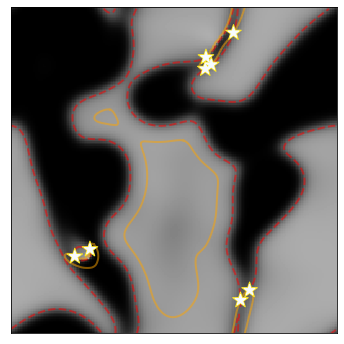

In [28]:
#visually verify system
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt_prev)
x_values,y_values,pid_values=pdict.get_current_locations()
dict_topo=comp_dict_topo_simple(img,dimgdt,t)
t=t_prev

ntips=len(dict_topo['x'])
img=inVc[...,0]
dimgdt=dVcdt[...,0]
V_threshold=-40
# compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
# dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
print(f"{ntips} tips are present at time t={int(t_prev)}.")
fig = ShowDomain(img,dimgdt,x_values,y_values,0.*x_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
                 area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,txt.shape[0],0,txt.shape[1]])
# fig = ShowDomain(img,dimgdt,np.array([xyavg[0]]),np.array([xyavg[1]]),np.array([0]),V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
#                  area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
# ax=fig.get_axes()[0]
# ax.scatter([xyavg[0]],[xyavg[1]],s=1000,c='yellow',marker='*')
# plt.show(fig)

In [15]:
txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1000)
# txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=100)
# txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=10)
# txt_prev,t_prev,min_sigma_max=find_stopping_point(dt,pdict,txt_prev,t_prev,save_every_n_frames=1)
beep(3)

KeyboardInterrupt: 

In [32]:
#TODO: save txt_prev


{'x': [146.4691443741714],
 'y': [26.450258743365257],
 't': [750.0],
 'lesser_pid': [1],
 'lesser_arclen': [8.708053745567],
 'greater_pid': [3],
 'greater_arclen': [45.83069486175157]}

# TODO: plot the activation arclength as it goes to zero for the last living tip

In [ ]:
pid_lst=pdict.get_dead_particles()
pid_lst

In [16]:
pid_lst=pdict.get_alive_particles()
pid_lst

[6, 7]

In [17]:
pdict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

1 tips are present at time t=930.


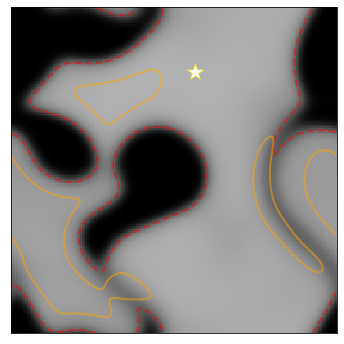

In [24]:
#visually verify system
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt_prev)
x_values,y_values=pdict.get_current_locations()
ntips=x_values.shape[0]
img=inVc[...,0]
dimgdt=dVcdt[...,0]
V_threshold=-40
# compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
# dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
print(f"{ntips} tips are present at time t={int(t_prev)}.")
fig = ShowDomain(img,dimgdt,x_values,y_values,0.*x_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
                 area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,txt.shape[0],0,txt.shape[1]])
# fig = ShowDomain(img,dimgdt,np.array([xyavg[0]]),np.array([xyavg[1]]),np.array([0]),V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
#                  area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
# ax=fig.get_axes()[0]
# ax.scatter([xyavg[0]],[xyavg[1]],s=1000,c='yellow',marker='*')
# plt.show(fig)

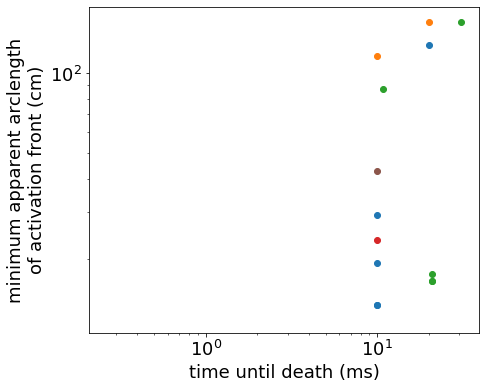

In [54]:
# plot sigma_max of the lesser_arclen versus time for all particles, centering about their last recorded time
fontsize=18
saving=False
figsize=(7,6)
fig,ax=plt.subplots(figsize=figsize)

pid_lst=list(pdict.keys())
# pid_lst=pdict.get_alive_particles()
for pid in pid_lst:
    #extract values
    sigma_max_values=np.array(pdict[pid].lesser_arclen_lst)
    t_values=np.array(pdict[pid].t_lst)
    t_until_death_values=t_values[-1]-t_values
    x_values=t_until_death_values
    y_values=sigma_max_values
    
    #plot values
    ax.scatter(x_values,y_values)

#format
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
ax.set_xlabel('time until death (ms)', fontsize=fontsize)
ax.set_ylabel('minimum apparent arclength\nof activation front (cm)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.set_xscale('log')
ax.set_yscale('log')
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
    plt.close()

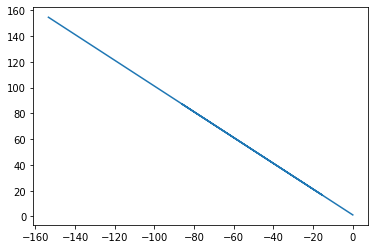

In [27]:
pid=pid_lst[0]
sigma_max_values=np.array(pdict[pid].lesser_arclen_lst)
t_values=np.array(pdict[pid].lesser_arclen_lst)
t_until_death_values=t_values[-1]-t_values
x_values=t_until_death_values
y_values=sigma_max_values
plt.plot(x_values,y_values)

In [40]:
t_values

array([154.68706098,  17.56937965,  16.51058622,  16.51058622,
        87.25726125,   8.52618134,   8.52618134,   7.96418374,
         7.96418374,   7.41765492,   7.41765492,   6.79229556,
         6.79229556,   6.25046338,   6.25046338,   5.64644656,
         5.64644656,   4.93735477,   4.93735477,   4.1756479 ,
         4.1756479 ,   2.80562171,   2.80562171,   2.53539862,
         2.53539862,   2.18665422,   2.18665422,   1.85183652,
         1.85183652,   1.52838018,   1.52838018,   1.21403736,
         1.21403736])

# TODO: make to_df function for pdict
- TODO: bilinear interpolate txt to each contour point 
- DONE: make video of death starting at time t=900
- DONE: color particles by pid?
- TODO(later): color lesser arclen value contours ... or voltage

In [85]:
particle=pdict[0]

In [83]:
x_values=np.array(particle.x_lst)
y_values=np.array(particle.y_lst)
t_values=np.array(particle.t_lst)
pid_values=(pid+0.*x_values).astype('int')
# list(particle.lesser_pid_lst)[0]
lesser_pid_values=np.array(particle.lesser_pid_lst)

array([{5}, {3}, {2}, {3}, {0}, {1}, {0}], dtype=object)

In [80]:
pd.DataFrame({'x':particle.x_lst,
            'y':particle.y_lst,
            't':particle.t_lst,
             'pid':pid_values,
            'lesser_pid':lesser_pid_values})
              

NameError: name 'lesser_pid_values' is not defined

In [76]:
int(list({4})[0])

4

In [77]:
particle.lesser_arclen_lst

[127.31249832937719,
 13.426353656524968,
 29.383992629609292,
 19.32020200812073,
 13.426353656524968,
 12.052653303007027,
 12.052653303007027]

# dev

# TODO(later): dev find_particle_death method
- DONE:  save as csv method for particle and pdict using pandas
- DONE: use existing bilinear interpolation method to get arcV_values
- TODO: highlight activation front
- TODO: make movie with activation fronts highlighted
- TODO: measure sigma_max versus time for several death events
- TODO: define a force along the string

In [ ]:
- TODO: use existing bilinear interpolation method to get arcV_values


In [90]:
bilinear_interpolate_channel?

In [71]:
#compute spiral tip location and topological number
contours_a = find_contours(img,        level = V_threshold)
contours_b = find_contours(dimgdt,     level = 0.)
s1_lst, s2_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours_a,contours_b,width, height,jump_threshold = 2,size_threshold = 6)
dict_topo={'x':x_lst,'y':y_lst,'s1':s1_lst,'s2':s2_lst, 't':t}

In [91]:
contour=contours_a[0]
interpolate_txt_to_contour

In [83]:
contour_values=interpolate_txt_to_contour(contour,width,height,txt)

In [ ]:
#TODO: use interpolate_txt_to_contour in comp_dict_topo to get txt colors at node points

#TODO(later, if relevant/interesting forces emerge): use deque datatype to grow locally found tips to other tips
#TODO(later): compute estimates of node_id / segment position in cython

In [87]:
#compute spiral tip location and topological number
contours_a = find_contours(img,        level = -40)
contours_b = find_contours(dimgdt,     level = 0)
jump_threshold = 10;size_threshold = 4
s1_lst, s2_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours_a,contours_b,width,height,jump_threshold,size_threshold)
comp_dict_topo_full_color(img,dimgdt,t,txt,

In [96]:
a={}
a.update({'a':'a','b':'c'})

# TODO: highlight activation front by curvature

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


In [54]:
#load a mesh from Luo-Rudy that is near termination
txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_900.0.npz'
t=900.
txt=load_buffer(txt_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]

# #jit compile arclength module to llvm machine code
# locate_nearest_point_index = get_locate_nearest_point_index(width=width,height=height)
# distance_L2_pbc=get_distance_L2_pbc(width=width,height=height)
# project_point_2D=get_project_point_2D(width=width,height=height)
# subtract_pbc=get_subtract_pbc(width=width,height=height)
# comp_perimeter=get_comp_perimeter(width=width,height=height)
# fix_node_id=get_fix_node_id(width=width,height=height)
# retval=get_arclength_module(width=width,height=height)
# locate_node_indices_simple, locate_node_indices, compute_arclength_values, compute_arclength, compute_arclength_values_upto_next, compute_arclength_values_for_tips=retval


In [55]:
#jit compile spiral tip observation
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=-40,level2=0)
comp_dict_topo_full_color=get_comp_dict_topo_full_color(width=width,height=height,level1=-40,level2=0)


In [56]:
#measure tips that are already present
img=inVc[...,0];dimgdt=dVcdt[...,0]
V_threshold=-40
dict_topo=comp_dict_topo_full_color(img,dimgdt,t,txt)


In [57]:
dict_topo.keys()

dict_keys(['x', 'y', 's1', 's2', 't', 'pid', 'greater_pid', 'lesser_pid', 'greater_arclen', 'lesser_arclen', 'greater_arclen_values', 'lesser_arclen_values', 'greater_mean_V', 'lesser_mean_V', 'greater_mean_curvature', 'lesser_mean_curvature', 'greater_xy_values', 'lesser_xy_values', 'greater_V_values', 'lesser_V_values', 'greater_curvature_values', 'lesser_curvature_values'])

In [59]:
ds=5.
pid_in=3
voltage_values=dict_topo['greater_V_values'][pid_in]
curvature_values=dict_topo['greater_curvature_values'][pid_in]*ds/width
xy_values=dict_topo['greater_xy_values'][pid_in]

(array([22.,  7., 15., 11., 19.,  8., 11., 11., 15.,  8.]),
 array([2.12411581e-05, 1.01434951e-03, 2.00745786e-03, 3.00056622e-03,
        3.99367457e-03, 4.98678292e-03, 5.97989127e-03, 6.97299962e-03,
        7.96610798e-03, 8.95921633e-03, 9.95232468e-03]),
 <BarContainer object of 10 artists>)

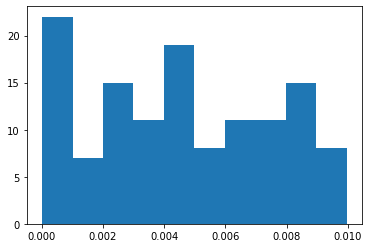

In [71]:
boo=curvature_values<.01
plt.hist(curvature_values[boo])

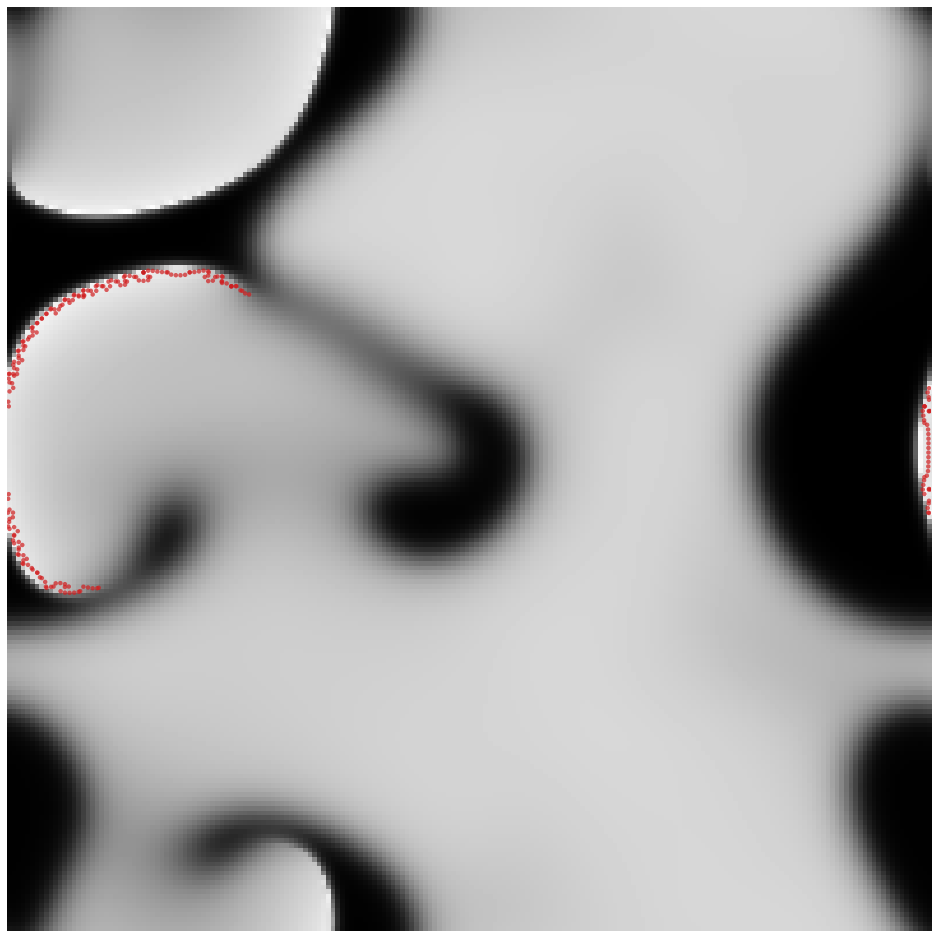

In [133]:
# x_values = (xy_values[:-1,0]+xy_values[1:,0])/2.
# y_values = (xy_values[:-1,1]+xy_values[1:,1])/2.
# c_values = (curvature_values[1:]+curvature_values[:-1])/2.

x_values = xy_values[:,0]
y_values = xy_values[:,1]
c_values = curvature_values
# c_values = voltage_values

figsize=(17,17)
fig,ax=plt.subplots(figsize=figsize)
plt.imshow(img,cmap='gray')
plt.scatter(x_values,y_values, c=c_values, edgecolor='none',vmin=V_threshold,vmax=15,cmap='Reds',alpha=0.7,s=20)
# plt.scatter(x_values,y_values, c=cm.hot(c_values), edgecolor='none',vmin=0.,vmax=.01)

plt.axis('off')
plt.show()

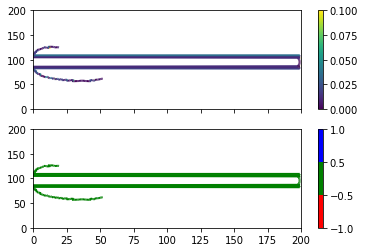

In [102]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(c_segments.min(), c_segments.max())
norm = plt.Normalize(0,0.1)
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(c_segments)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)



fig.colorbar(line, ax=axs[0])

# Use a boundary norm instead
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(c_segments)
lc.set_linewidth(2)
line = axs[1].add_collection(lc)
fig.colorbar(line, ax=axs[1])

axs[0].set_xlim([0,200])
axs[0].set_ylim([0,200])
# axs[0].set_xlim(x.min(), x.max())
# axs[0].set_ylim(-1.1, 1.1)
plt.show()

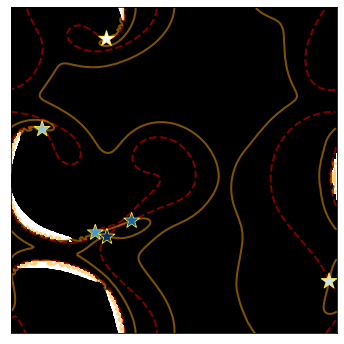

In [125]:
x_values=np.array(dict_topo['x'])
y_values=np.array(dict_topo['y'])
c_values=np.array(dict_topo['pid'])/5
fig=ShowDomain(img, dimgdt, x_values, y_values, c_values, V_threshold, t)

# TODO(later): smooth out xy_values on contours before computing things like curvature.  Use moving average?  Ask WJ...